In [1]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import sim_helper_funcs as hfunc
import save_load_data as sldat


In [4]:
# Now, load the all the data
dt=0.01
robData = []
datasets = ['test_reset']
data_N = len(datasets)

for i in range(data_N):
    robData.append( sldat.load_object(datasets[i], folder=r"D:\msc_data") )

# We assume that all these parameters are identical for each dataset
# get number of robots
robot_N = robData[0].ids.shape[0]
# Get number of runs
runs_N = robData[0].biases.shape[2]
# Get length of runs 
pos_N = robData[0].pos.shape[2]

In [5]:
# Compute MAE and ANEES for all the datasets

anees_all = np.zeros((data_N, robot_N, pos_N))
anis_all = np.zeros((data_N, robot_N, pos_N))
err_pos = np.zeros((data_N, robot_N, 3, pos_N, runs_N))
err_bias = np.zeros((data_N, robot_N, 3, pos_N, runs_N))
MAE_all = np.zeros((data_N, robot_N, 2, pos_N)) # 2 because we track only the position and orientation error
MAE_bias = np.zeros((data_N, robot_N, 2, pos_N))

rad_sel = np.array([[True],[False],[False]])
rad_sel_ext = np.repeat(rad_sel, pos_N, axis=1)
pos_ind = [0, 1, 2]
bias_ind = [5, 6, 7]
prob = 0.997

for i in range(data_N):
    for j in range(robot_N):
        x_est=robData[i].x_log[j, pos_ind, :, :]
        x_true=robData[i].pos[j,0:3,:] 
        P = robData[i].P_log[j][pos_ind][:, pos_ind, :, :]

        # Compute anees
        temp_anees, t, r1, r2 = sim.ANEES(x_est=x_est, x_true=x_true, P=P, rad_sel=rad_sel, prob=prob, dt=dt)
        anees_all[i,j,:] = temp_anees

        # Compute anis
        df_nis = 2 
        temp_nis, t_nis, r1_2df, r2_2df = sim.ANIS(nis=robData[i].RB_nis_log[j], df=df_nis, dt=dt, prob=prob)
        anis_all[i,j,:] = temp_nis

        # Compute error 
        for k in range(runs_N):
            err_pos[i,j,:,:,k] = mf.subtractState(robData[i].pos[j], robData[i].x_log[j, pos_ind,:, k], rad_sel_ext) 
            err_bias[i,j,:,:,k] = robData[i].x_log[j, bias_ind,:, k] - np.repeat(robData[i].biases[j,:,k:k+1], pos_N, axis=1)
    
    # From the error, compute the MAE:
    MAE_all[i,:,0] =  (1/runs_N)*np.sum(np.linalg.norm(err_pos[i,:,1:], axis=1), axis=2)
    MAE_all[i,:,1] = (1/runs_N)*np.sum(abs(err_pos[i,:,0]), axis=2)
    MAE_bias[i,:,0] = (1/runs_N)*np.sum(np.linalg.norm(err_bias[i,:,1:], axis=1), axis=2)
    MAE_bias[i,:,1] = (1/runs_N)*np.sum(abs(err_bias[i,:,0]), axis=2)


In [6]:
# From here, do analysis on the computed ANEES and MAE

idx_start = round(100/dt) # ignore all measurements before 100 s

mean_MAE = np.mean(MAE_all[:,:,:,idx_start:], axis=3)
mean_mean_MAE = np.mean(mean_MAE,axis=1)
anees_count = np.zeros((data_N, robot_N))
anis_count = np.zeros((data_N, robot_N))
mean_anees_count = np.zeros((data_N))
mean_anis_count = np.zeros((data_N))
anees_mean = np.mean(anees_all[:,:,idx_start:], axis=2)

for i in range(data_N):
    for j in range(robot_N):
        anees_count[i,j] = (1/(pos_N-idx_start))*np.sum( (anees_all[i,j,idx_start:] > r2))*100 # assume that r1 and r2 is identical for all measurements (which they are for aness)

        # For anis first calculate the numbe rof valid measurements:
        r2_2use = r2_2df # <---- set manually for correct nis (r2 for 3 df, r2_2df for 2df)
        valid_N = np.sum((anis_all[i,j,idx_start:] > 0))
        anis_count[i,j] = (1/valid_N)*np.sum( (anis_all[i,j,idx_start:] > r2_2use))*100

    mean_anees_count[i] = np.mean(anees_count[i], axis=0)
    mean_anis_count[i] = np.mean(anis_count[i], axis=0)
# Print results
extra_details = True
for i in range(data_N):
    print('***simulation Nr. ' + str(i) + ' ***')
    if extra_details:
        for j in range(robot_N):
            print('Robot: ' + str(j))
            print('Mean position error: {:.3f}, Mean orientation error: {:.3f}'.format(mean_MAE[i, j, 0], mean_MAE[i, j, 1]))
            print('ANEES outlier percentage {:.2f}, ANIS outlier percentage {:.2f}'.format(anees_count[i, j], anis_count[i, j]))
            print('ANEES mean {:.3f}'.format(anees_mean[i, j]))
    print('Total means')
    print('Mean-mean position error: {:.3f}, Mean-mean orientation error: {:.3f}'.format(mean_mean_MAE[i, 0], mean_mean_MAE[i, 1]))
    print('Mean ANEES outlier percentage {:.2f}, Mean ANIS outlier percentage {:.2f}'.format(mean_anees_count[i], mean_anis_count[i]))


***simulation Nr. 0 ***
Robot: 0
Mean position error: 8.733, Mean orientation error: 0.183
ANEES outlier percentage 60.70, ANIS outlier percentage 6.16
ANEES mean 2380831.396
Robot: 1
Mean position error: 7.276, Mean orientation error: 0.159
ANEES outlier percentage 66.66, ANIS outlier percentage 5.39
ANEES mean 949.443
Robot: 2
Mean position error: 3.637, Mean orientation error: 0.013
ANEES outlier percentage 12.24, ANIS outlier percentage 1.33
ANEES mean 39.778
Total means
Mean-mean position error: 6.549, Mean-mean orientation error: 0.118
Mean ANEES outlier percentage 46.54, Mean ANIS outlier percentage 4.30


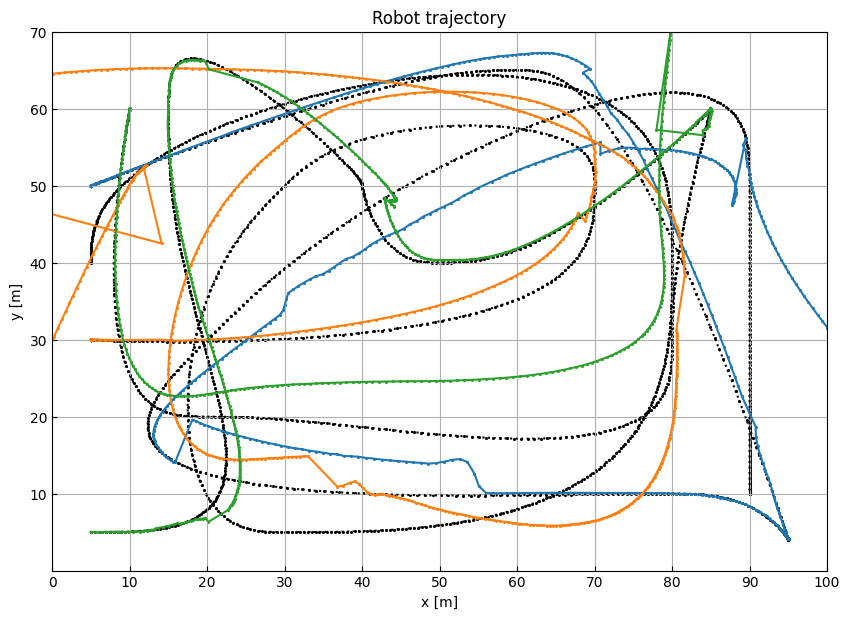

In [13]:
# And plot:
s_idx = 0
d_idx = 0

fig, ax = rp.setup_plot()
# Plot ground truth
for i in range(robot_N):
    rp.plot_position(ax, robData[d_idx].pos[i,:,::100], color='black', marker=None, linestyle=':', draw_arrow=False, label='Robot 1 reference') # fix label

# Plot states of robots:
for i in range(robot_N):
    rp.plot_position2(ax, robData[d_idx].x_log[i,:,::100,s_idx], None, color=None, marker=None, draw_arrow=False, label='Robot 1 trajectory')

# Plot anchor positions
#for anc in anchors:
#    anc.draw_position(ax=ax, color='black')


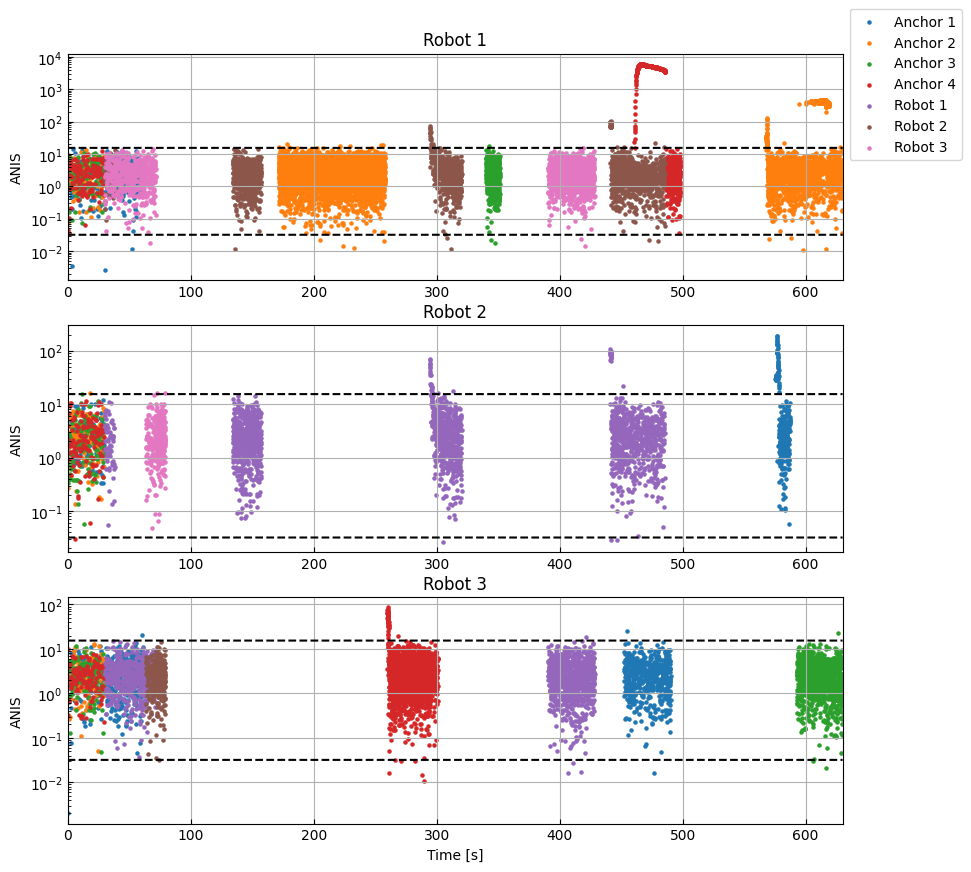

In [8]:
# ANIS analysis
fig, axnis = plt.subplots(robot_N, figsize=(10,10))
# Three df
df = 3
for i in range(robot_N):
    rp.plot_ANIS_rb(ax=axnis[i], 
                nis=robData[d_idx].RB_nis_log[i], 
                rb_ids=robData[d_idx].rb_ids[i], 
                pos_ids=[1, 2, 3, 4, 111, 222, 333], 
                labels=['Anchor 1', 'Anchor 2', 'Anchor 3', 'Anchor 4', 'Robot 1', 'Robot 2', 'Robot 3'],
                df=df, 
                dt=dt, 
                prob=0.997)

axnis[0].legend(loc='lower left', bbox_to_anchor=(1, 0.5))
for i in range(robot_N):
    if not (i==robot_N-1):
        axnis[i].set_xlabel(None)
    axnis[i].set_title('Robot ' + str(i+1))
    

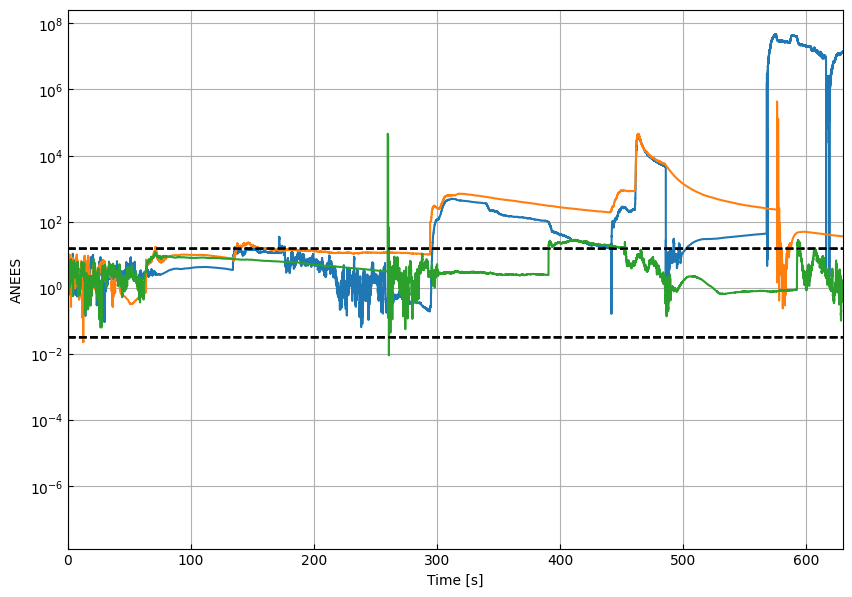

In [9]:
# Plot metrics:
# ANEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, ax_anees = plt.subplots(1, figsize=(10,7))
anees_sel = np.array([[True],[False],[False]])
pos_ind = [0, 1, 2]

for i in range(robot_N):
        r1_line = np.ones_like(anees_all[d_idx, i])*r1
        r2_line = np.ones_like(anees_all[d_idx, i])*r2
        # Plot anees
        ax_anees.semilogy(t, anees_all[d_idx, i])
        ax_anees.semilogy(t, r1_line, color='black', linestyle='--')
        ax_anees.semilogy(t, r2_line, color='black', linestyle='--')
        ax_anees.set_xlabel("Time [s]")
        ax_anees.set_ylabel("ANEES")
        ax_anees.grid()
        ax_anees.tick_params(axis='x', direction='in', which='both')
        ax_anees.tick_params(axis='y', direction='in', which='both')
        ax_anees.set_xlim([0,t[-1]])

#ax_anees.set_ylim([0.001, 100])

#ax_anees.legend()

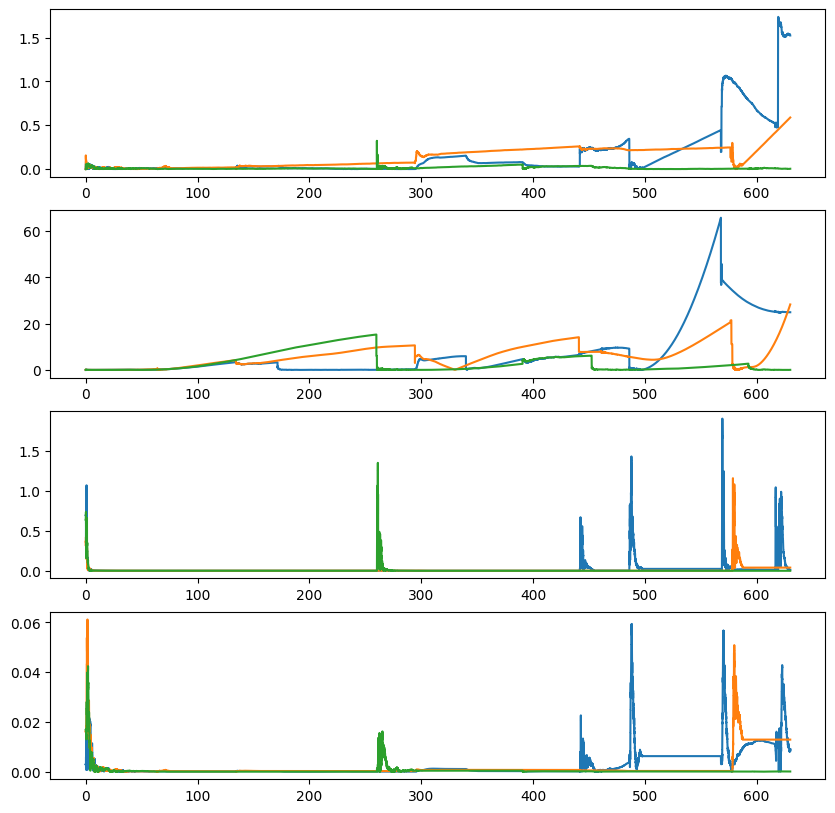

In [10]:
# Plot absolute error
fig, axerr = plt.subplots(4, figsize=(10,10))
for i in range(robot_N):
    axerr[0].plot(t, MAE_all[d_idx, i, 1, :], label=("UAV " + str(i)))
    axerr[1].plot(t, MAE_all[d_idx, i, 0, :], label=("UAV " + str(i)))
    axerr[2].plot(t, MAE_bias[d_idx, i, 0, :], label=("UAV " + str(i)))
    axerr[3].plot(t, MAE_bias[d_idx, i, 1, :], label=("UAV " + str(i)))
